In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import sys
import time

# NOTE: make sure "path/to/datafold" is in sys.path or PYTHONPATH if datafold is not installed
from datafold.dynfold import DiffusionMaps
from datafold.utils.plot import plot_pairwise_eigenvector
import datafold.pcfold as pfold

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfd = tf.contrib.distributions
import pandas as pd

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from visualization import *
from data import *

## Word2Vec data

In [4]:
import gensim

# Load Google's pre-trained Word2Vec model with desired limit
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)
embedding_mat, labels = create_embedding_matrix(model)

In [5]:
# test class labels as array
word_array = ['Taylor_Swift', 'horizon', 'socks', 'God', 'fairy', 'Kanye_West', 'trump', 'Hollywood', 'ghost', 
              'dragon', 'Sinatra', 'Hulk', 'beach', 'Los_Angeles', 'New_York', 'horrible', 'dumb', 'Star_Wars', 
              'fashion', 'Chanel', 'fantasy', 'movies', 'Lebron', 'basketball', 'tennis', 'president', 'chocolate','language',
              'computer', 'space', 'game', 'kebab', 'evil', 'surgeon', 'Batman', 'Facebook', 'culinary', 'Pilates', 'clown', 
              'queen', 'Turkey', 'guitar', 'education', 'useful', 'sleep', 'coffee', 'ocean', 'theater', 'Germany','tequila',
              'soldier', 'biology', 'key','aquarium', 'engineer', 'lavender','Harry_Potter', 'sweater', 'dog', 'lipstick', 
              'pencil', 'Muse', 'neighbor', 'muffin', 'koala', 'zebra', 'oxygen', 'rainforest', 'Einstein', 'medical', 
              'Metallica']
# creating the test set, vl is the word embeddings
bl, vl, label_list = create_corpus(word_array, 1000, model)

## Use datafold diffusion maps to create 2D embedding

In [6]:
X_pcm = pfold.PCManifold(vl) # test set as input
X_pcm.optimize_parameters(result_scaling=2)
print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

# create diffusion map embedding
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon), 
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))
dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap = dmap.transform(X_pcm)

epsilon=1.5865374806371484, cut-off=5.40602445602417


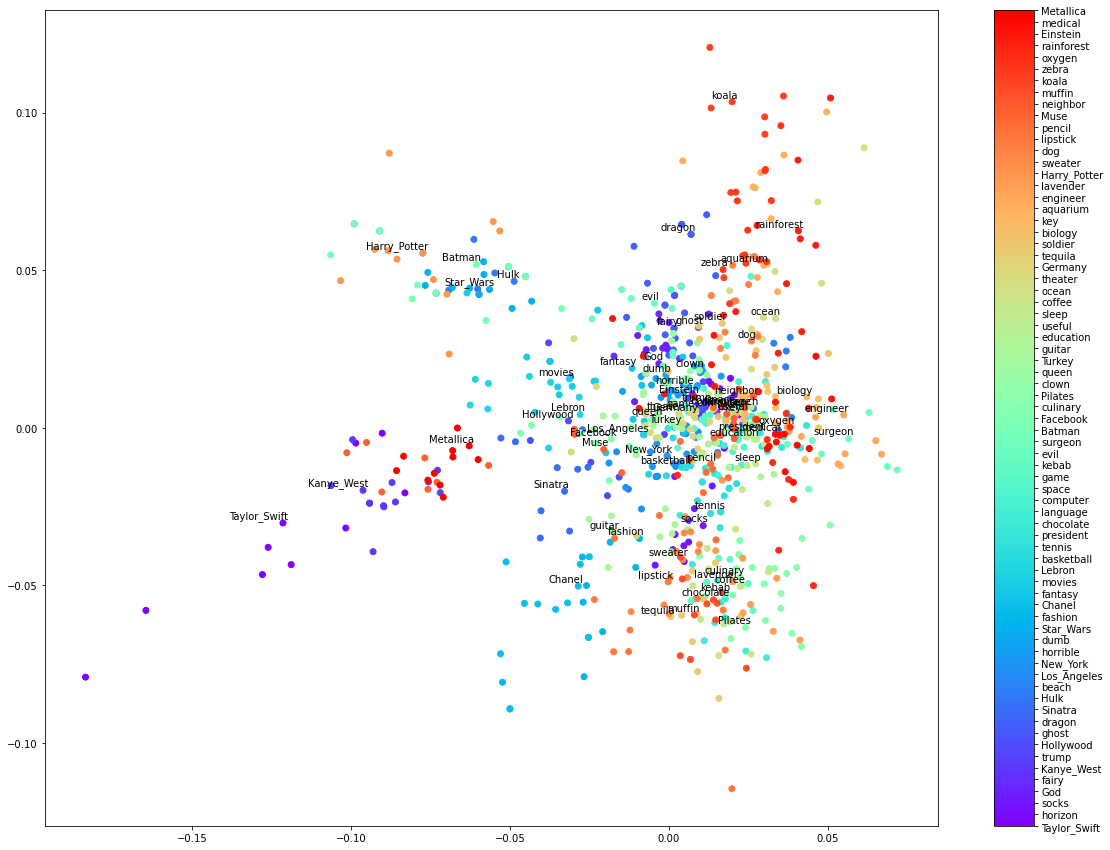

In [7]:
# plot the created embedding
plot_embedding(X_dmap, bl, label_list, text_data=True, p=11, figsize=(20, 15), name="datafold_250")

## Create embedding with PCA

In [8]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)

In [9]:
new_values = tsne_model.fit_transform(vl) # test set as input

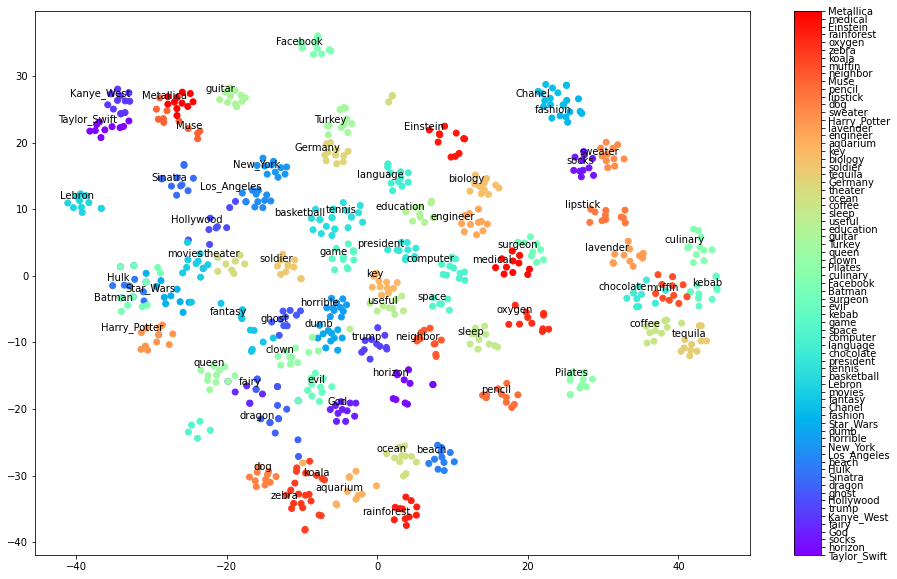

In [10]:
plot_embedding(new_values, bl, label_list, text_data=True, p=11, name="pca_250")

## Trying CIFAR-10

In [11]:
cifar_data = tf.keras.datasets.cifar10.load_data()
train, test = cifar_data
train_x = train[0]
train_y = train[1]
test_x = test[0]
test_y = test[1]
cifar_labels =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
resized_train_x, resized_test_x = resize_images(train_x, test_x) # resize images

In [13]:
limit = 5000

In [14]:
X = resized_train_x[0:limit, :] # get limited number of sample in order to not overwhelm the method
y = train_y[0:limit,0]

In [15]:
X_pcm = pfold.PCManifold(X) # resized images as input
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap = dmap.transform(X_pcm)

epsilon=27.31939410321306, cut-off=22.433052331180942


In [16]:
cif_lab = []
for i in y:
    cif_lab.append(cifar_labels[y[i]]) # define string labels for each point

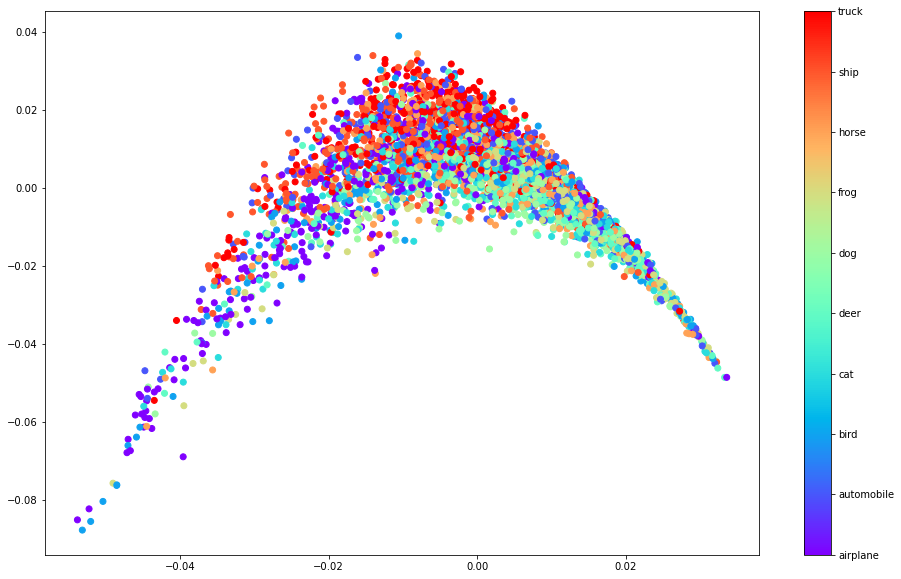

In [17]:
plot_embedding(X_dmap, cif_lab, y, text_data=False, text_labels=cifar_labels, name="cifar_5000")

### CIFAR with PCA

In [18]:
cifar_tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
cifar_values = tsne_model.fit_transform(X)

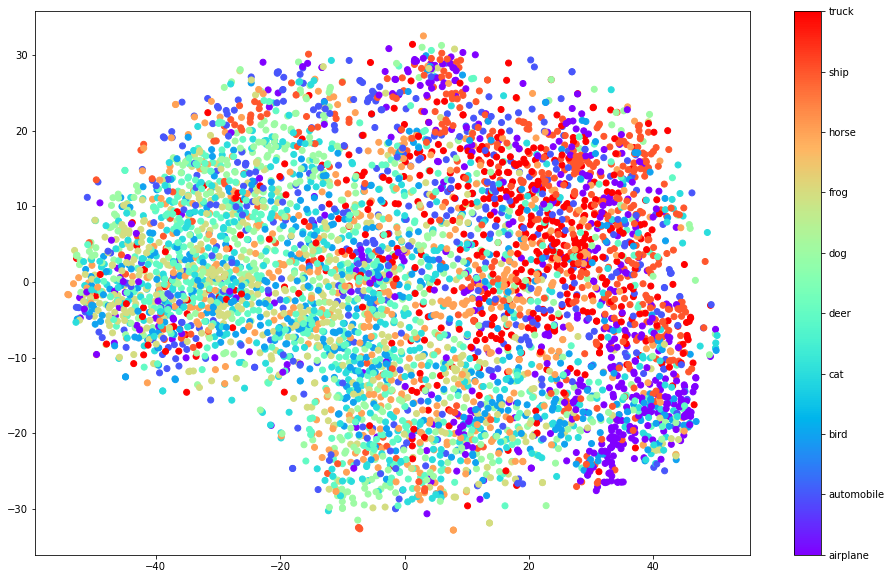

In [19]:
plot_embedding(cifar_values, cif_lab, y, text_data=False, text_labels=cifar_labels, name="cifar_pca_5000")

### Datafold Without reshaping

In [20]:
# trying with 1000 data points
X_notresized = train_x[0:1000, :]
y_notresized = train_y[0:1000, 0]

In [21]:
X_notresized = X_notresized.reshape(-1, 32*32*3)

In [22]:
X_pcm = pfold.PCManifold(X_notresized)
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap_notresized = dmap.transform(X_pcm)

epsilon=5581621.299948731, cut-off=10139.88481196902


In [23]:
cif_lab_notresized = []
for i in y:
    cif_lab.append(cifar_labels[y_notresized[i]]) # define string labels for each point

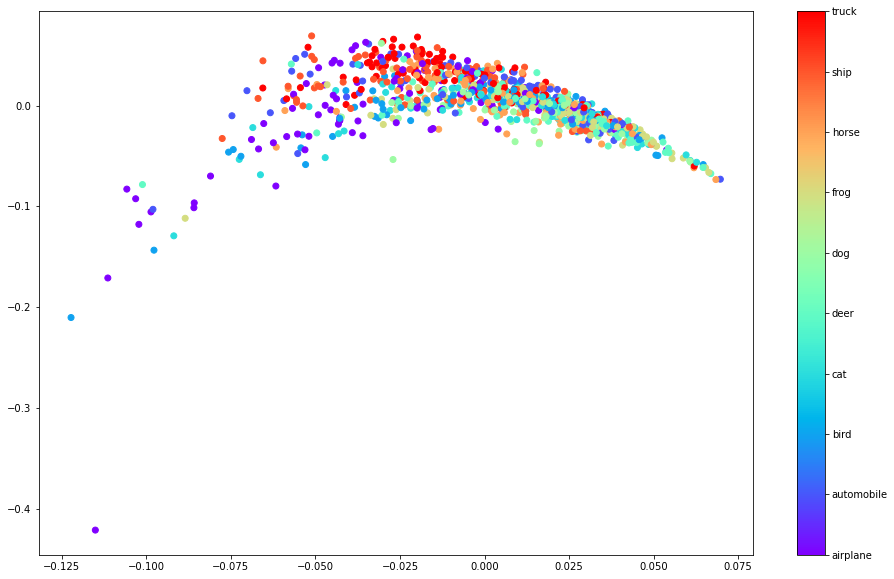

In [24]:
plot_embedding(X_dmap_notresized, cif_lab_notresized, y_notresized, text_data=False, text_labels=cifar_labels, name="cifar_1000_full")